In [30]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine, make_circles, make_moons
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
X, y = load_wine(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0
)

In [4]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [5]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(3):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print(f"MV {label}: {mean_vecs[label]}")

MV 0: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]
MV 1: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]
MV 2: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]


In [6]:
X_test_std.shape

(54, 13)

In [7]:
d = X_test_std.shape[1]  # Number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(3), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print(f"Scaled within-class scatter matrix: {S_W.shape[0]}x{S_W.shape[1]}")

Scaled within-class scatter matrix: 13x13


In [8]:
mean_overall = np.mean(X_train_std, axis=0)
d = X_train_std.shape[1]  # Number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # Make column vector
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print(f"Between-class scatter matrix: {S_B.shape[0]}x{S_B.shape[1]}")

Between-class scatter matrix: 13x13


In [9]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [10]:
eigen_pairs = [
    (np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))
]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print("Eigenvalues in descending order:")
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:
349.61780890599397
172.7615221897938
3.3428382148413644e-14
2.842170943040401e-14
2.5545786180111397e-14
1.753393918073425e-14
1.753393918073425e-14
1.6579193995960887e-14
1.6579193995960887e-14
8.242524002707208e-15
8.242524002707208e-15
6.36835506006027e-15
2.97463437554573e-15


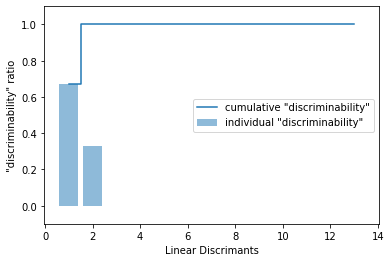

In [11]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(
    range(1, 14),
    discr,
    alpha=0.5,
    align="center",
    label='individual "discriminability"',
)
plt.step(range(1, 14), cum_discr, where="mid", label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel("Linear Discrimants")
plt.ylim([-0.1, 1.1])
plt.legend(loc="best")
plt.show()

In [12]:
# Creating transformation matrix W from eigenpairs.
w = np.hstack(
    (eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real)
)
print("Matrix W:")
print(w)

Matrix W:
[[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


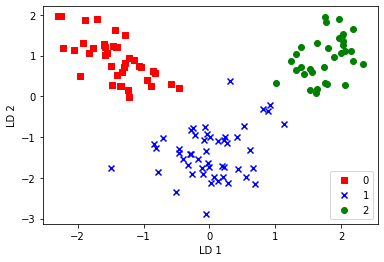

In [13]:
# Projecting samples onto the new feature space.

X_train_lda = X_train_std.dot(w)
colors = list("rbg")
markers = list("sxo")
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(
        X_train_lda[y_train == l, 0],
        X_train_lda[y_train == l, 1] * (-1),
        c=c,
        label=l,
        marker=m,
    )
plt.xlabel("LD 1")
plt.ylabel("LD 2")
plt.legend(loc="lower right")
plt.show()

In [14]:
# LDA via scikit-learn
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

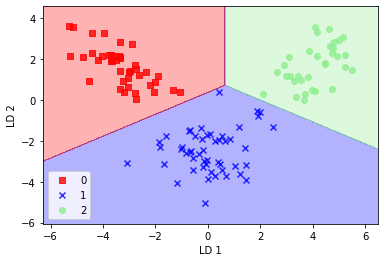

In [15]:
%run plot_decision_regions.py

lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel("LD 1")
plt.ylabel("LD 2")
plt.legend(loc="lower left")
plt.show()

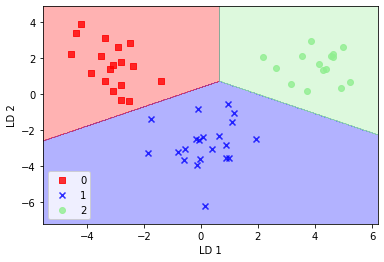

In [16]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel("LD 1")
plt.ylabel("LD 2")
plt.legend(loc="lower left")
plt.show()

In [17]:
import numpy as np
from scipy.linalg import eigh
from scipy.spatial.distance import pdist, squareform

In [18]:
def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ----------
    X: {NumPy ndarray}, shape = [n_samples, n_features]

    gamma: float
      Tuning parameter of RBF kernel

    n_components: int
      Number of principal components to return

    Returns
    -------
    X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
      Projected dataset
    """
    # Calculates pairwise squared Euclidean distance
    # in MxN dimensional dataset.
    sq_dists = pdist(X, "sqeuclidean")

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = np.exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix.
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected samples)
    X_pc = np.column_stack([eigvecs[:, i] for i in range(n_components)])
    return X_pc

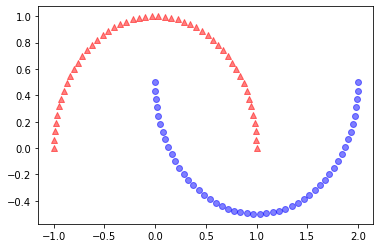

In [19]:
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", marker="^", alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", marker="o", alpha=0.5)

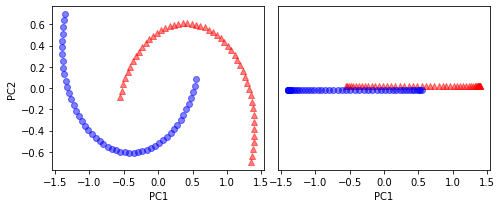

In [20]:
# Project via standard PCA
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1], color="red", marker="^", alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1], color="blue", marker="o", alpha=0.5)

ax[1].scatter(
    X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02, color="red", marker="^", alpha=0.5
)
ax[1].scatter(
    X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02, color="blue", marker="o", alpha=0.5
)
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel("PC1")

plt.tight_layout()
plt.show()

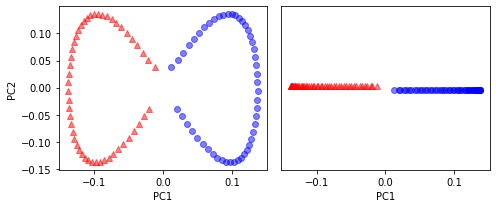

In [21]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1], color="red", marker="^", alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1], color="blue", marker="o", alpha=0.5)

ax[1].scatter(
    X_kpca[y == 0, 0], np.zeros((50, 1)) + 0.02, color="red", marker="^", alpha=0.5
)
ax[1].scatter(
    X_kpca[y == 1, 0], np.zeros((50, 1)) - 0.02, color="blue", marker="o", alpha=0.5
)
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel("PC1")
plt.tight_layout()
plt.show()

# Example 2 - Separating concentric circles

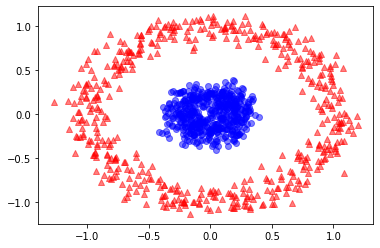

In [24]:
X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", marker="^", alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", marker="o", alpha=0.5)

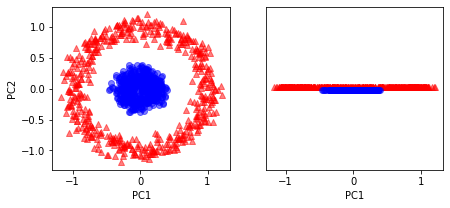

In [26]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1], color="red", marker="^", alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1], color="blue", marker="o", alpha=0.5)

ax[1].scatter(
    X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02, color="red", marker="^", alpha=0.5
)
ax[1].scatter(
    X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02, color="blue", marker="o", alpha=0.5
)

ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel("PC1")
plt.show()

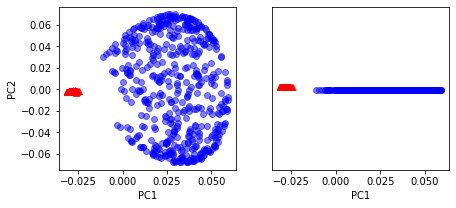

In [28]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1], color="red", marker="^", alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1], color="blue", marker="o", alpha=0.5)

ax[1].scatter(
    X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02, color="red", marker="^", alpha=0.5
)
ax[1].scatter(
    X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02, color="blue", marker="o", alpha=0.5
)

ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel("PC1")
plt.show()

Text(0, 0.5, 'PC2')

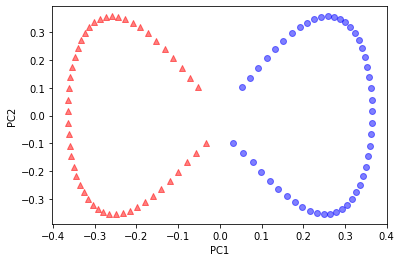

In [31]:
X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=12, kernel="rbf", gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)
plt.scatter(
    X_skernpca[y == 0, 0], X_skernpca[y == 0, 1], color="red", marker="^", alpha=0.5
)
plt.scatter(
    X_skernpca[y == 1, 0], X_skernpca[y == 1, 1], color="blue", marker="o", alpha=0.5
)
plt.xlabel("PC1")
plt.ylabel("PC2")